# RegGenome challenge

RegGenome have trained a regulatory / non-regulatory (RNR) classifier based on the language used in the text of documents published by legislative bodies.

The classifier has performed very well in development, scoring over 99% accuracy.

However, after the model was deployed to production many non-regulatory documents started being misclassified as regulatory. The new publisher web crawlers have been optimised for high recall and the large number of spurious documents is causing high load on downstream systems and analysts.

Below is the notebook which builds and tests the model. Please take an hour to consider the following questions:

1. Why is the model performing worse in a production setting?
2. How could we have predicted this?
3. What strategies could we employ to improve the performance? Please consider:
    a) Technical / DS strategies
    b) Non-technical / organisational strategies

Please edit or add to the notebook to demonstrate technical strategies for 2 & 3a. Due to time constraints they do not need to be fully formed but should demonstrate your programming ability and a grasp of the issues involved.

**Please spend no more than an hour on this challenge.**

We will spend 20-30 minutes of our interview discussing your proposals. Good luck!


# Notes
## Data Exploration

### Examine class balance
1. Large class imbalance
1.1. Update the data
1.2. Synthetic Generation
1.3. Change the prediction-function threshold


### Examine typical data

## AI Best Practices
1. No cross validation - > Pure overfitting
2. Define your metrics: Accuracy is a bias trap.

## NLP
1. Real pre-processing.
2. Bad featurization
 -> Top 1000 are mostly meaningless.
 -> no regularisation
 -> Numbers
 -> Punctuation
 -> bad tokenisation
 -> No stopword filtering

## Representation
1. TFIDF over words
2. Distributed semantics

### Document features
-> Pull out titles using heuristics.

### External Knoweledge
-> Ontology Tagging
-> -> Leads to more interesting graph representations

## Modelling
1. Can we do anaomoly detection?
2. Standard Models
3. Graph representations
4. Distributed Symantics


## Evalution
1. Accuracy may not be domain specific
2. At a minimum look at the confusion matrix.

## Programming practice
1. looped list look ups are very innefficient, cast as a set as a minimum.
2. all of this should be pipelined really for feature generation





In [ ]:
import sys
import nltk
import sklearn
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

from nltk.tokenize import word_tokenize

from tools import print_metrics



nltk.download('stopwords')
nltk.download('punkt')

print('Python: {}'.format(sys.version))
print('NLTK: {}'.format(nltk.__version__))
print('Scikit-learn: {}'.format(sklearn.__version__))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))

In [57]:
# Load the original dataframe for examiniation
original_df = pd.read_table('rnr-examples.csv', sep=",", header=0, encoding='utf-8')

# Load the extended dataframe for experiments
df = pd.read_csv('./data/extended_data.csv')

texts = df['text']
labels = df['label']

# Data Exploration

Here we examine the class imbalance, and the feature representation

Text(0.5, 1.0, 'Original Class Imbalance')

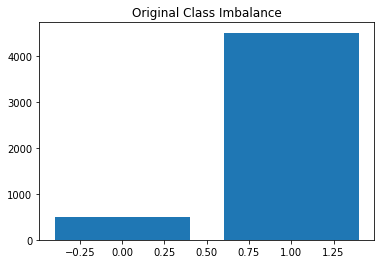

In [58]:

classes = Counter(original_df["label"].to_list())
plt.bar(classes.keys(),classes.values())
plt.title("Original Class Imbalance")

Text(0.5, 1.0, 'Augmented Class Imbalance')

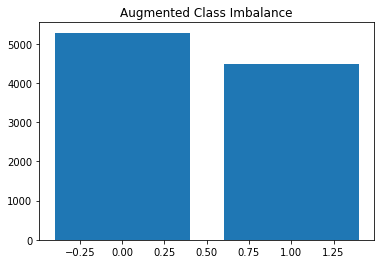

In [59]:
classes = Counter(df["label"].to_list())
plt.bar(classes.keys(),classes.values())
plt.title("Augmented Class Imbalance")

In [61]:
# Create bag of words
all_words = []

for text in texts:
    words = word_tokenize(text)
    for word in words:
        all_words.append(word)
        
all_words = nltk.FreqDist(all_words)

# Inspect the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

Number of words: 151898
Most common words: [('the', 230501), ('of', 184134), ('.', 170667), (',', 157027), ('and', 107322), ('to', 102492), (')', 96025), ('(', 91487), ('in', 69894), ('a', 60552), ('or', 45598), ('for', 39553), ('by', 31011), (':', 29829), ('be', 29459)]


In [62]:
# Use the 1,000 most common words as features
# This could be a count vectorizer, that would add presence + counts
def find_features(text, top_n=1000):
    # Move to within feature
    word_features = list(all_words.keys())[:top_n]
    # This will be very slow, lets at least do a set look up
    words = set(word_tokenize(text))
    features = {}
    for word in word_features:
        features[word] = (word in words)
    return features

In [ ]:
# Extract all the features for all the texts
texts = list(zip(texts, labels))

# define a seed for reproducibility
seed = 1
np.random.seed = seed
np.random.shuffle(texts)

# call find_features function for each SMS message
# This is an inefficient function, replace with a count-vectorizer
feature_sets = [(find_features(text), label) for (text, label) in texts]

In [9]:
# Investigate the richness of these feature sets
all_false = [f for f in feature_sets if len(set(f[0].values())) == 1]
print(f"This representation creates {len(all_false)} empty vectors")

This representation creates 328 empty vectors


# Benchmark the Given Approach
Here we benchmark the given approach, focusing on accuracy, over a single test-train split.

In [ ]:
# Train Random Forest classifier
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Create a train-test split.
train, test = train_test_split(feature_sets)

model = SklearnClassifier(RandomForestClassifier())
model.train(feature_sets)
false_accuracy = nltk.classify.accuracy(model, feature_sets)*100
print("Classifier Accuracy: {}".format(false_accuracy))


model = SklearnClassifier(RandomForestClassifier())
model.train(train)
true_accuracy = nltk.classify.accuracy(model, test)*100

print(f"False Accuracy {false_accuracy} \n True Accuracy {true_accuracy}")

## Cross Fold Validation

Here we demonstrate how we can use cross validation to get a better picture of the performance of the type of model

In [ ]:
scoring = ['precision_macro', 'recall_macro','f1_macro','accuracy']


clf = Pipeline([
     ('vect', CountVectorizer(max_features=1000)),
     ('clf',  RandomForestClassifier()),
])

scores = cross_validate(clf, df["text"],df["label"], scoring=scoring)
scores



# Data Pre-processing

Here we use a custom defined Scikit-learn prerpocessor that achieves:

1. Removal of punctuation
2. Removeal of numerical values
3. lowercasing.

In [ ]:
# Import a custom preprocessor that can be used in pipelines
from tools import Preprocessor

In [ ]:
import nltk
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
test, train = train_test_split(df)

text_clf = Pipeline([
     ('preprocessor', Preprocessor()),
     ('vect', CountVectorizer(stop_words=stopwords)),
     ('tfidf', TfidfTransformer()),
     ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),
])

# Train the new model
text_clf.fit(train["text"], train["label"])


In [ ]:
y_pred = text_clf.predict(test["text"])
print_metrics("Preprocessed Text", y_pred, test["label"])


In [ ]:
scores = cross_validate(clf, df["text"],df["label"], scoring=scoring)
scores